# BrainOwl

A classifier tuned for neuroimaging based on the OWL norm and the SpaRSA solver.

This notebook is versioning the [Decoding with SpaceNet: face vs house object recognition](http://nilearn.github.io/auto_examples/02_decoding/plot_haxby_space_net.html#decoding-with-spacenet-face-vs-house-object-recognition) `nilearn` example.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from brainowl import brainowl
from sklearn.preprocessing import LabelBinarizer
from nilearn import datasets

In [2]:
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby(data_dir='/tmp/nilearn_data')

In [3]:
import pandas as pd

# Load target information as string and give a numerical identifier to each
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral['labels']
condition_mask = conditions.isin(['face', 'house'])

# Split data into train and test samples, using the chunks
condition_mask_train = (condition_mask) & (behavioral['chunks'] <= 6)
condition_mask_test = (condition_mask) & (behavioral['chunks'] > 6)

# Apply this sample mask to X (fMRI data) and y (behavioral labels)
# Because the data is in one single large 4D image, we need to use
# index_img to do the split easily
from nilearn.image import index_img
func_filenames = haxby_dataset.func[0]
X_train = index_img(func_filenames, condition_mask_train)
X_test = index_img(func_filenames, condition_mask_test)
y_train = conditions[condition_mask_train]
y_test = conditions[condition_mask_test]

# Compute the mean epi to be used for the background of the plotting
from nilearn.image import mean_img
background_img = mean_img(func_filenames)

In [4]:
from nilearn.input_data import NiftiMasker

mask_filename = haxby_dataset.mask

# For decoding, standardizing is often very important
# note that we are also smoothing the data
masker = NiftiMasker(mask_img=mask_filename, smoothing_fwhm=4,
                     standardize=True, memory="nilearn_cache", memory_level=1)
X_train = masker.fit_transform(X_train)
X_test = masker.transform(X_test)

We do not use feature selection as in the `nilearn` example, the classifier will learn from all the voxels.

In [5]:
sclf = brainowl.SparsaClassifier(loss='log', penalty='owl', alpha=8e-4, beta=8e-4)

In [7]:
sclf.fit(X_train, y_train)
y_pred = sclf.predict(X_test)

In [8]:
acc = (y_pred == y_test).mean()
print(f'Accuracy: {acc:.2%}')

Accuracy: 94.44%


In [9]:
coef = sclf.coef_

In [10]:
weight_img = masker.inverse_transform(coef)

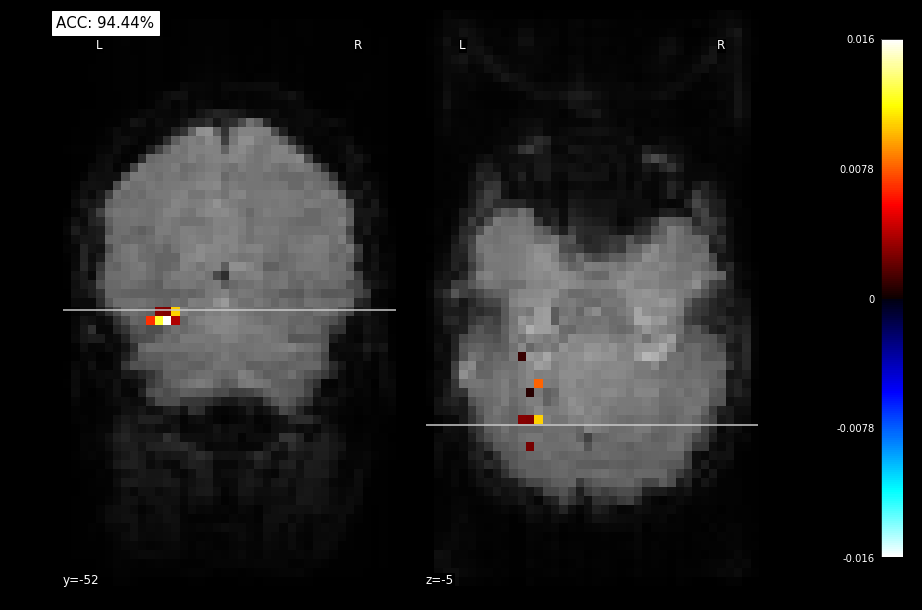

In [11]:
# Create the figure
from nilearn.plotting import plot_stat_map, show
f = plot_stat_map(weight_img, background_img, cut_coords=(-52, -5), display_mode='yz',
                  title=f'ACC: {acc:.2%}')
f.frame_axes.figure.set_size_inches(12, 8)

We can sacrifice some accuracy for interpretability.

In [12]:
sclf = brainowl.SparsaClassifier(loss='log', penalty='owl', alpha=5e-4, beta=5e-4)
sclf.fit(X_train, y_train)
y_pred = sclf.predict(X_test)
acc = (y_pred == y_test).mean()
print(f'Accuracy: {acc:.2%}')

Accuracy: 77.78%


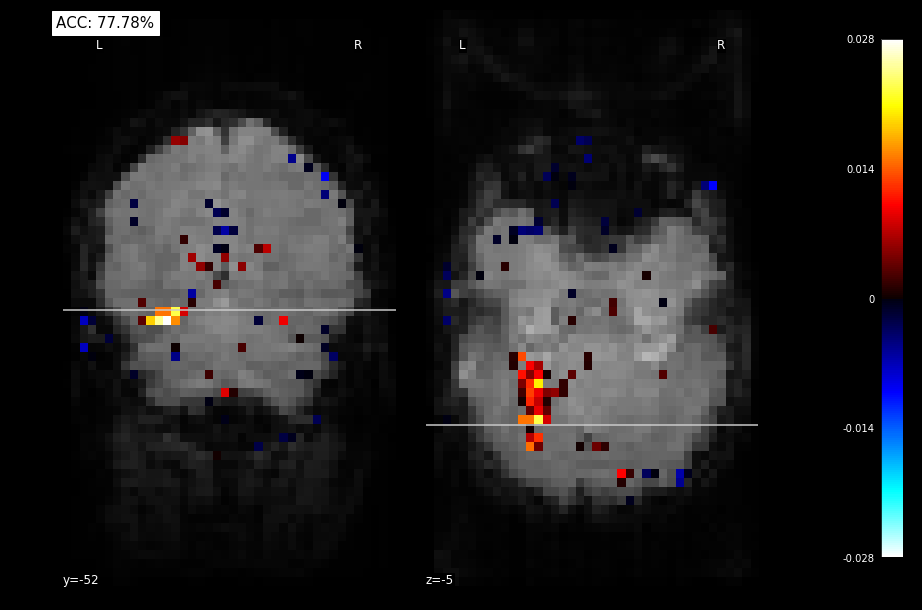

In [13]:
coef = sclf.coef_
weight_img = masker.inverse_transform(coef)

f = plot_stat_map(weight_img, background_img, cut_coords=(-52, -5), display_mode='yz',
                  title=f'ACC: {acc:.2%}')
f.frame_axes.figure.set_size_inches(12, 8)

Try again, changing the train and test sets.

In [14]:
condition_mask_train = (condition_mask) & (behavioral['chunks'] > 6)
condition_mask_test = (condition_mask) & (behavioral['chunks'] <= 6)

X_train = index_img(func_filenames, condition_mask_train)
X_test = index_img(func_filenames, condition_mask_test)
y_train = conditions[condition_mask_train]
y_test = conditions[condition_mask_test]

In [15]:
X_train = masker.fit_transform(X_train)
X_test = masker.transform(X_test)

In [17]:
sclf.fit(X_train, y_train)
y_pred = sclf.predict(X_test)

In [18]:
acc = (y_pred == y_test).mean()
print(f'Accuracy: {acc:.2%}')

Accuracy: 84.92%


In [19]:
coef = sclf.coef_

In [20]:
weight_img = masker.inverse_transform(coef)

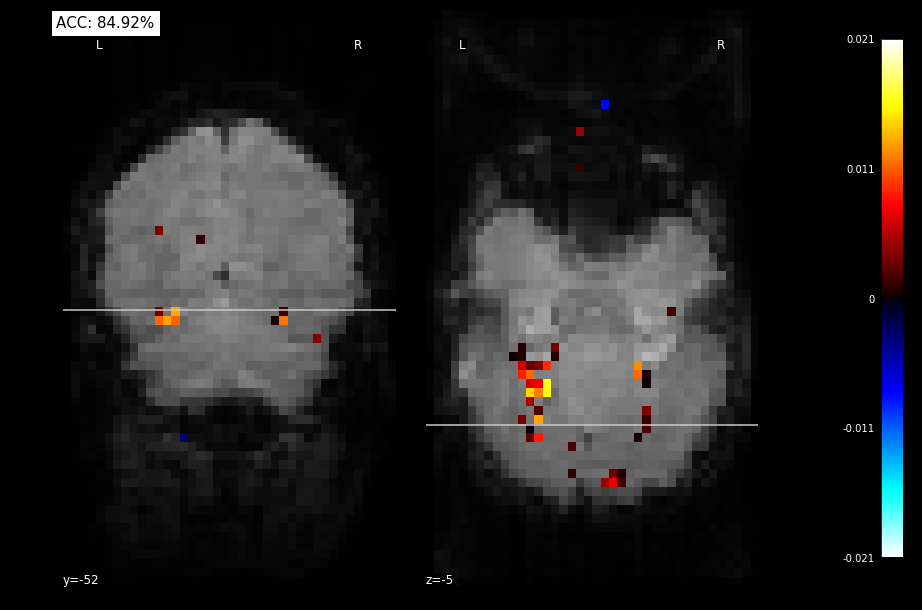

In [21]:
f = plot_stat_map(weight_img, background_img, cut_coords=(-52, -5), display_mode='yz',
                  title=f'ACC: {acc:.2%}')
f.frame_axes.figure.set_size_inches(12, 8)

----